## Phasing of single diffraction pattern (Fig. 11)

In [1]:
# Use autoreload
%load_ext autoreload
%autoreload 2

# Import modules
import sys, h5py
import numpy as np
import scipy.ndimage as ndimage
import spimage
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Configuration (Experiment)
distance_back  = 2.4 #[m]
distance_front = 0.497 #[m]
pixelsize = 110e-6 #[m]
wavelength = 0.2262e-9 #[m]
downsampling = 4

### 1. Loading data from file

In [3]:
# Loading the signal (assembled)
filename = "../analysis/phasing/phasing.h5"
N = 5000
with h5py.File(filename, 'r') as f:
    recons  = f['real_space_final'][:N]
    fourier = f['fourier_space_final'][:N]
    support = f['support_final'][:N]
    rerror  = f["real_error"][:N]
    ferror  = f["fourier_error"][:N]

### 2. Validation using PRTF

In [4]:
valid = (ferror < 0.2151) & (rerror < 0.1402)
print valid.sum()
print recons.shape

4429
(5000, 128, 128)


In [5]:
# Calculate PRTF
output_prtf = spimage.prtf(recons, support, enantio=True, translate=True)

In [6]:
# Collect PRTF results
superimage = output_prtf['super_image']
prtf_2d    = output_prtf['prtf']

In [7]:
# Save to file
with h5py.File('../analysis/phasing/prtf.h5', 'w') as f:
    f['super_image'] = superimage
    f['prtf'] = prtf_2d

In [17]:
nx, ny = prtf_2d.shape[1], prtf_2d.shape[0]
xx,yy = np.meshgrid(np.arange(nx),np.arange(ny))
mask_radial = np.sqrt((xx-nx/2)**2 + (yy-ny/2)**2) < nx/2
prtf_centers, prtf_radial = spimage.radialMeanImage(prtf_2d, msk=mask_radial, output_r=True)
prtf_qr = x_to_q(prtf_centers, distance_front)
limit_qr = prtf_qr[np.abs(ndimage.gaussian_filter1d(prtf_radial,2) - (1/np.e)).argmin()]

In [22]:
# Pixelsize in real space
dx = wavelength * distance_front / (intensities_cropped.shape[0] * pixelsize*downsampling) #[m/px]
print "One pixel in real space corresponds to %.1f nm" %(dx*1e9)
print "The support should have a size (diameter) of about %.2f px" %(signal_diameter / (dx*1e9))

One pixel in real space corresponds to 2.0 nm
The support should have a size (diameter) of about 21.66 px


### 3. Plotting

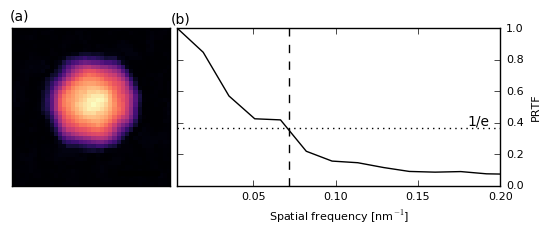

The PRTF drops below 1/e at a resolution of 13.45 nm


In [29]:
plot = plotting.Plot(fontsize=8, rows=1, cols=3, legend=True, legend_frameon=False, exclude=(1,2), save_pdf=True)
plot.add_axes((1,0),2,1, padx=0)
plot.xlabel = ['', r'Spatial frequency [nm$^{-1}$]']
plot.ylabel = ['', 'PRTF']
plot.title_label = 2*['']

plot.plotting_a_map(0, np.abs(superimage)[46:-44,45:-45], cmap='magma')
plot.axes[0].set_xticks([])
plot.axes[0].set_xticklabels([])
plot.axes[0].set_yticks([])
plot.axes[0].set_yticklabels([])
plot.plotting_a_rectangle(0, 25, 34, 20./(1e9*dx), 1, facecolor='k', edgecolor='k')
#plot.axes[0].text(15+20./(1e9*dx), 34, '40 nm', ha='center', va='bottom', fontsize=10, color='k')
plot.axes[0].text(-1, -5, '(a)', va='top', ha='left', fontsize=10)

plot.plotting_traces(1, [prtf_qr[:-5][::4]], 
                     [prtf_radial[:-5].reshape((15,4)).mean(axis=1)], 
                     [''], ylim=[0,1],xlim=[prtf_qr[0],0.2],
                     linestyles=['-'], linewidths=[1], markers=[None],
                     mecs=['k'], mfcs=['k'], colors=['k'])
plot.axes[1].axhline(1/np.e, ls=':', color='k')
plot.axes[1].axvline(1/14., color='k', ls='--')
plot.axes[1].tick_params(labelright='on', labelleft='off')
plot.axes[1].yaxis.set_label_position('right')
plot.axes[1].text(0, 1.1, '(b)', va='top', ha='left', fontsize=10)
plot.axes[1].text(0.18, 1/np.e, '1/e', va='bottom')

plot.save('/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/fig_phasing.pdf')
plot.show()
print "The PRTF drops below 1/e at a resolution of %.2f nm" %(1./limit_qr)

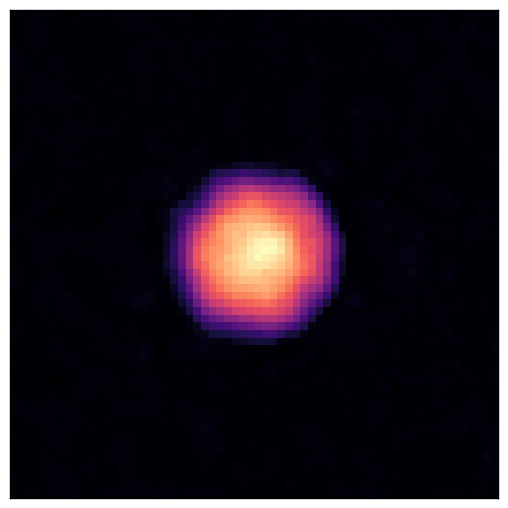

In [13]:
plot = plotting.Plot(fontsize=8, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, np.abs(recons[0][32:-32,32:-32]), cmap='magma')
#plot.plotting_a_rectangle(0, 100, 118, 40./(1e9*dx), 2, facecolor='w', edgecolor='w')
#plot.axes[0].text(100+20./(1e9*dx), 116, '40 nm', ha='center', va='bottom', fontsize=12, color='w')
#plot.save('../plots/phasing_recons.png')
plot.show()

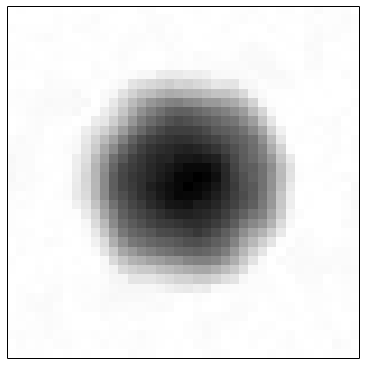

In [244]:
plot = plotting.Plot(fontsize=8, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, np.abs(superimage)[45:-45,45:-45], cmap='gray_r')
#plot.plotting_a_rectangle(0, 100, 118, 40./(1e9*dx), 2, facecolor='w', edgecolor='w')
#plot.axes[0].text(100+20./(1e9*dx), 116, '40 nm', ha='center', va='bottom', fontsize=12, color='w')
#plot.save('../plots/phasing_recons.png')
plot.show()

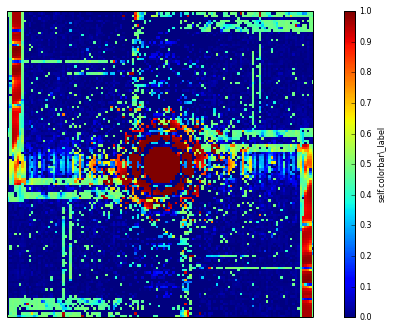

In [245]:
plot = plotting.Plot(fontsize=8, colorbar=True, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
prtf_img = ndimage.gaussian_filter(prtf_2d,2)
plot.plotting_a_map(0, spimage.downsample(prtf_2d,2) , mask=None, log=False, vmin=0, vmax=1, bad='0.8', under='w', cmap='jet')

In [15]:
# Convert index to q (in nm)
x_to_q = lambda x, d: (2*np.sin(np.arctan2(x*pixelsize*downsampling, d)/2.)) / wavelength / 1e9

The PRTF drops below 1/e at a resolution of 13.45 nm


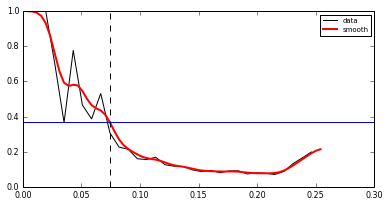

In [326]:
prtf_2d_down = spimage.downsample(prtf_2d,1)
nx, ny = prtf_2d_down.shape[1], prtf_2d_down.shape[0]
xx,yy = np.meshgrid(np.arange(nx),np.arange(ny))
mask_radial = np.sqrt((xx-nx/2)**2 + (yy-ny/2)**2) < nx/2
prtf_centers, prtf_radial = spimage.radialMeanImage(prtf_2d_down, msk=mask_radial, output_r=True)
prtf_qr = x_to_q(prtf_centers, distance_front)
limit_qr = prtf_qr[np.abs(ndimage.gaussian_filter1d(prtf_radial,2) - (1/np.e)).argmin()]
plot = plotting.Plot(fontsize=8, aspect=.5, legend=True, save_pdf=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_traces(0, [prtf_qr[:-1][::2], prtf_qr], 
                     [prtf_radial[:-1].reshape((32,2)).mean(axis=1), ndimage.gaussian_filter(prtf_radial,2)], 
                     ['data', 'smooth'], ylim=[0,1],
                     linestyles=['-','-'], linewidths=[1,2], markers=[None,None],
                     mecs=['k', 'r'], mfcs=['k', 'r'], colors=['k','r'])
plot.axes[0].axhline(1/np.e)
plot.axes[0].axvline(limit_qr, color='k', ls='--')
print "The PRTF drops below 1/e at a resolution of %.2f nm" %(1./limit_qr)

In [322]:
a = prtf_radial[:-1]
print a.reshape((32,2)).mean(axis=1)

[ 0.9999586   0.999872    0.99961689  0.69671045  0.36567556  0.77567288
  0.46528624  0.38636319  0.53094321  0.30675703  0.2257772   0.21342526
  0.15941823  0.15505289  0.1680353   0.12565738  0.11710605  0.11553361
  0.09639178  0.0866098   0.09354513  0.08043453  0.08996127  0.09122499
  0.07321978  0.07959106  0.07700502  0.06998797  0.08758578  0.13197644
  0.16432194  0.19817676]


In [19]:
# Loading the signal (assembled)
filename_signal = "../analysis/signal/signal_assembled.h5"
with h5py.File(filename_signal, 'r') as f:
    signal_data = np.rot90(f['data/data'][:], k=2)
    signal_mask = ~np.rot90(f['data/mask'][:].astype(np.bool), k=2)  
    signal_diameter = f['diameter'][...]
    signal_intensity = f['intensity'][...]
    signal_id = f['id'][...]

In [20]:
# Downsampling
downsampling = 4
intensities, mask = spimage.downsample(signal_data, downsampling, mask=signal_mask, mode='integrate')

In [21]:
# Cropping
cropping = 154
cx, cy = -2,-6
intensities_cropped = intensities[cropping+cy:-cropping+cy-1,cropping+cx:-cropping+cx-1]
mask_cropped = mask[cropping+cy:-cropping+cy-1,cropping+cx:-cropping+cx-1]
sh = intensities_cropped.shape
print "Shape after downsampling and cropping: ", sh

Shape after downsampling and cropping:  (128, 128)


In [204]:
mask_prtf = mask_cropped & np.rot90(np.rot90(mask_cropped))

In [205]:
mask_test = ndimage.gaussian_filter(prtf_2d,2)>1./np.e

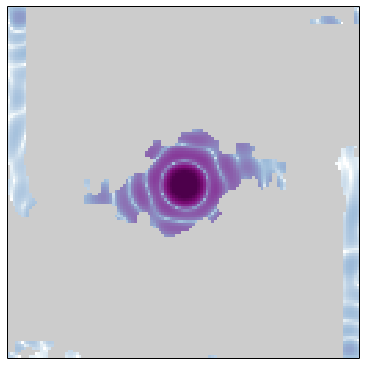

In [206]:
plot = plotting.Plot(fontsize=8, axes_visible=False, save_png=True)
plot.title_label = ['']
plot.xlabel = ['']
plot.ylabel = ['']
plot.plotting_a_map(0, np.abs(fourier[-1])**2, 
                    log=True, mask=mask_test, bad='0.8', under='w', vmin=1e-5, vmax=100, cmap='BuPu')
plot.show()

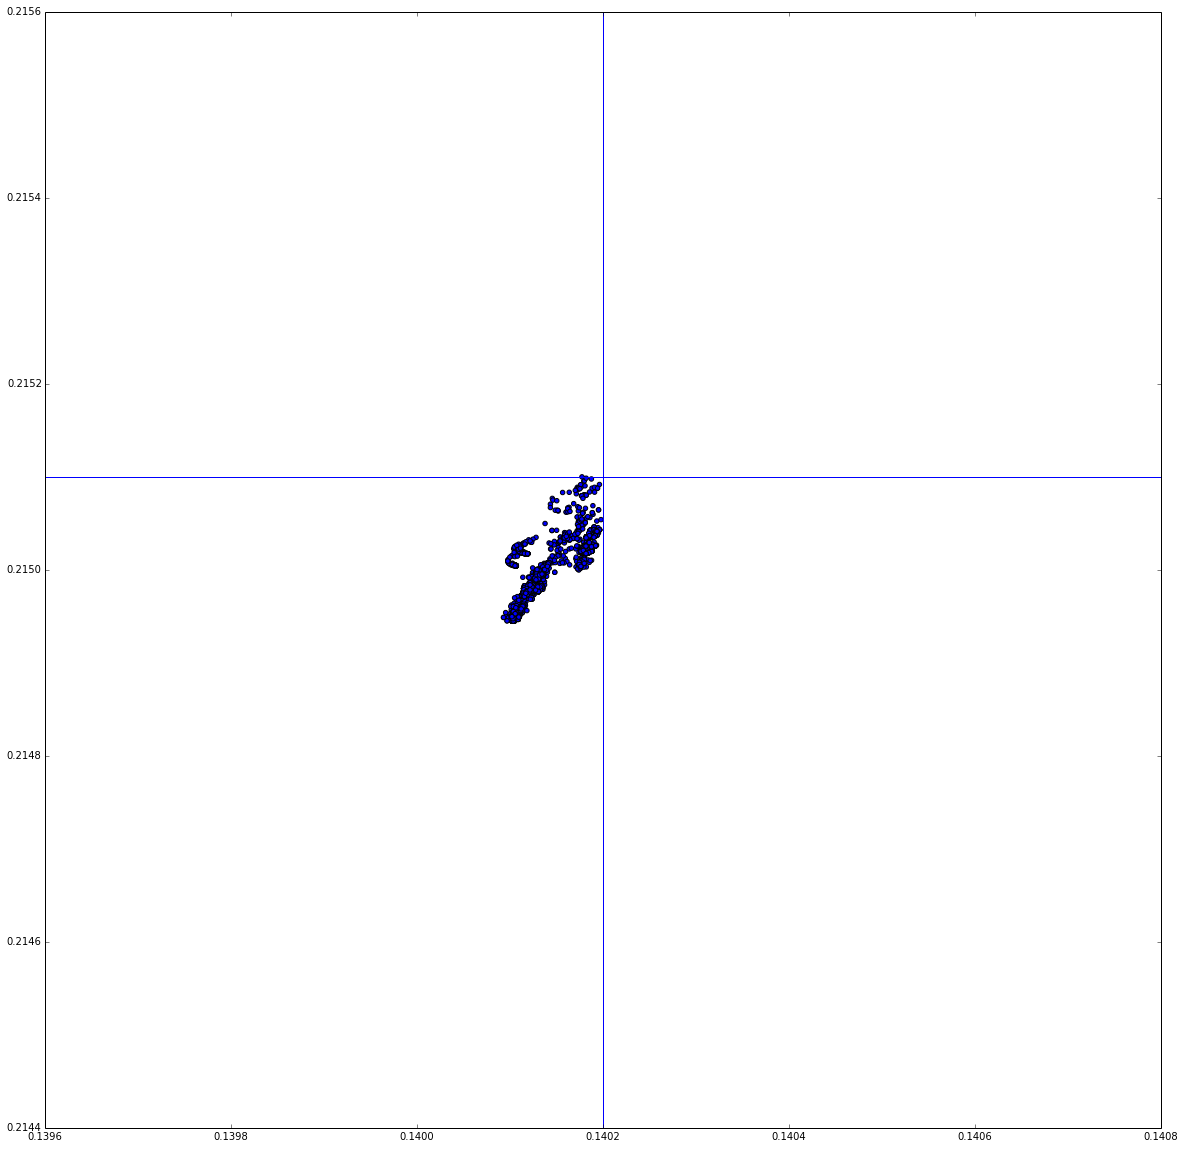

In [207]:
plotting.plt.figure(figsize=(20,20))
plotting.plt.scatter(rerror[valid], ferror[valid])
plotting.plt.axhline(0.2151)
plotting.plt.axvline(0.1402)
#plotting.plt.xlim([])
plotting.plt.show()

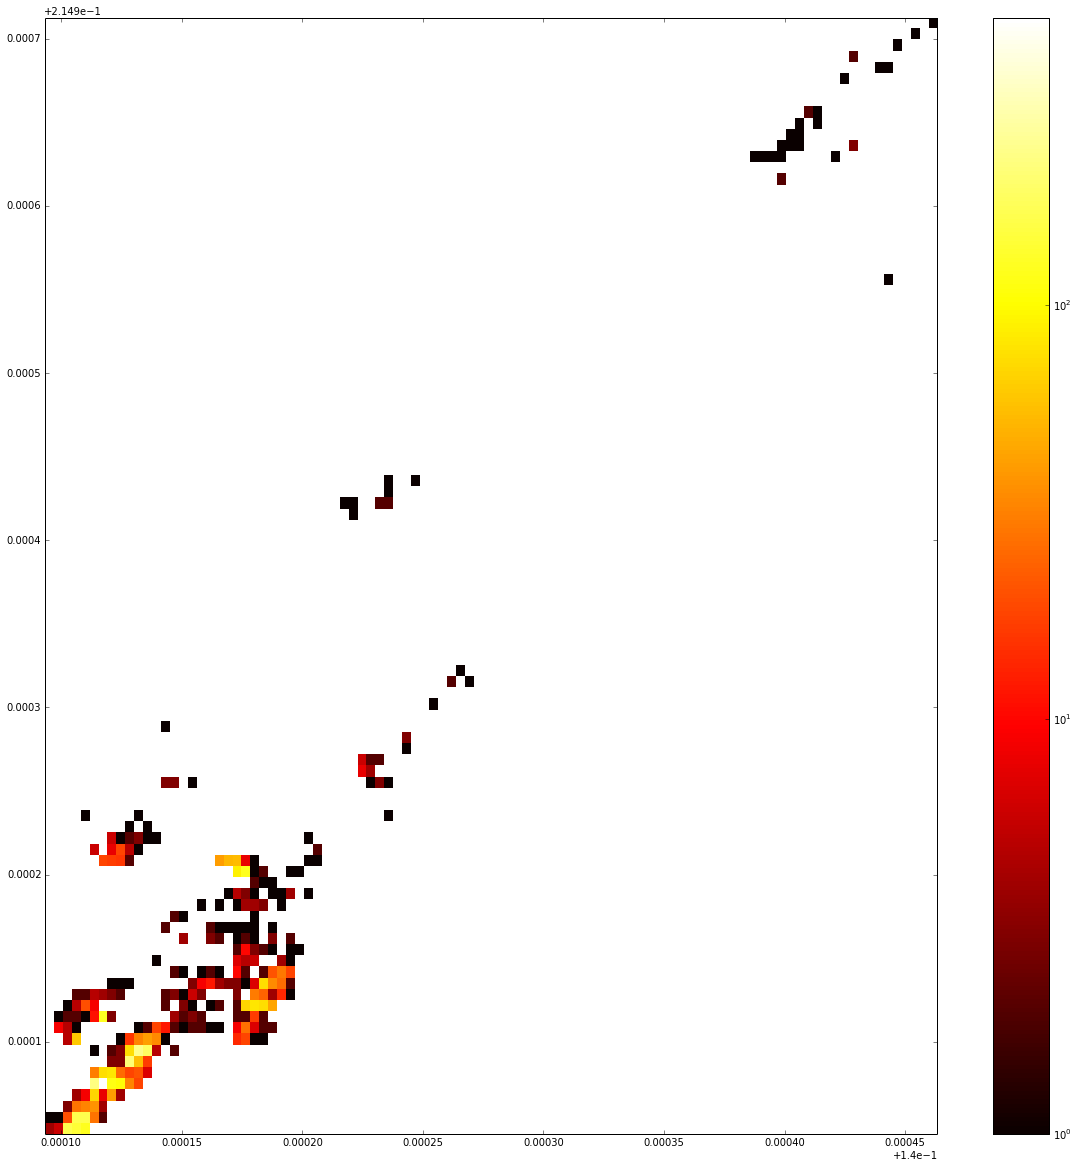

In [164]:

plotting.plt.figure(figsize=(20,20))
plotting.plt.hist2d(rerror, ferror, bins=100, norm=plotting.colors.LogNorm(), cmap='hot')
plotting.plt.colorbar()
plotting.plt.show()

In [258]:
prtf_radial

array([ 0.99996823,  0.99994898,  0.99991095,  0.99983305,  0.99971485,
        0.99951893,  0.93837595,  0.45504496,  0.22999571,  0.50135541,
        0.72132611,  0.83001965,  0.59767693,  0.33289555,  0.34220836,
        0.43051803,  0.51529592,  0.54659051,  0.41425946,  0.1992546 ,
        0.20735393,  0.24420047,  0.20235924,  0.22449127,  0.18416928,
        0.13466719,  0.15434502,  0.15576077,  0.16666824,  0.16940236,
        0.15371914,  0.09759562,  0.09323908,  0.14097302,  0.12352543,
        0.10754179,  0.10811552,  0.08466803,  0.08639944,  0.08682015,
        0.095833  ,  0.09125726,  0.08110753,  0.07976153,  0.08790917,
        0.09201337,  0.10191643,  0.08053356,  0.07133821,  0.07510135,
        0.07321905,  0.08596306,  0.07055307,  0.08345698,  0.0714032 ,
        0.06857274,  0.0723103 ,  0.10286126,  0.13245481,  0.13149807,
        0.15868817,  0.1699557 ,  0.19247253,  0.203881  ,  0.25103539])

In [287]:
def rebin( a, newshape ):
        '''Rebin an array to a new shape.
        '''
        assert len(a.shape) == len(newshape)

        slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
        coordinates = np.mgrid[slices]
        indices = coordinates.astype('i')   #choose the biggest smaller integer index
        return a[tuple(indices)]

In [289]:
print type(prtf_radial[:-1])
print rebin(prtf_radial[:-1], (32,))

<type 'numpy.ndarray'>
[ 0.99881101  0.98780692  0.91204506  0.72510797  0.58206993  0.58486521
  0.54347873  0.46255735  0.43205711  0.36061618  0.26533982  0.21353021
  0.18245171  0.16548207  0.15558529  0.13883799  0.11930365  0.11195348
  0.10358369  0.09415849  0.08932857  0.08846855  0.08572651  0.08507115
  0.08028463  0.07787156  0.0744831   0.07760301  0.0935836   0.12395722
  0.15673482  0.17404737]
